In [2]:
import muspy as mp
import numpy as np
import copy as cp
import random
import tqdm as tqdm
import torch

import sys
sys.path.append(sys.path[0] + "/..")
import lib.prd as prd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
ds_muspy = mp.datasets.EssenFolkSongDatabase("../data")
len(ds_muspy)

9034

#### muspy dataset to prd representation

In [10]:
ds_prd = []
fail_counter = 0
nr = 9
for i, music in enumerate(ds_muspy):
    try:
        track_prd = prd.from_muspy(music)
    except Exception:
        continue
    else:
        ds_prd.append(torch.tensor(track_prd))
print(f"successfully converted: {len(ds_prd)}/{len(ds_muspy)}")

successfully converted: 9010/9034


In [5]:
def random_uniform_float(a: float = 0, b: float = 1) -> float:
    rnd = np.random.random()
    return rnd * (b - a) + a

In [6]:
def tensor_prepend_append(tensor, pre, ap):
    return torch.concat((torch.tensor([pre]), tensor, torch.tensor([ap])), dim=0)

class DatasetPRD(torch.utils.data.Dataset):

    PADDING = -3  # unencoded (0 as code)
    SOT_DURATION = -2  # unencoded
    EOT_DURATION = -1  # unencoded
    SOT_DUR_CODE = 1
    EOT_DUR_CODE = 2

    def __init__(self, prd_tunes: list[torch.Tensor], *, xy_split: float|list[float]=0.5, sot_code: int=129, eot_code: int=130, trnasposition_augment_range: tuple[int]|None=None):
        self.xy_split = xy_split
        self.sot_code = sot_code  # sot <=> start of tune
        self.eot_code = eot_code  # eot <=> end of tune
        self.transposition_range = trnasposition_augment_range
        self.duration2code = {}
        self.code2duration = []
        self.create_code_translation(prd_tunes)
        self.tunes = self.prepare_tunes(prd_tunes)

    def random_interval(self):
        lowest, highest = self.transposition_range
        return np.random.randint(lowest, highest + 1)

    def transpose(self, tune):
        if self.transposition_range is None:
            return tune
        
        interval = self.random_interval()
        return prd.transpose(tune, interval)

    def create_code_translation(self, tunes: list[torch.Tensor]):
        set_of_durations = set(
            int(duration) for tune in tunes for duration in tune[:, 1]
        )
        padding_sot_eot = [self.PADDING, self.SOT_DURATION, self.EOT_DURATION]
        self.code2duration = padding_sot_eot + sorted(list(set_of_durations))
        self.duration2code = {dur: i for i, dur in enumerate(self.code2duration)}

    def encode_durations(self, prd_tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        encoded_tunes = []
        for tune in cp.deepcopy(prd_tunes):
            tune[:, 1] = tune[:, 1].apply_(lambda x: self.duration2code[x])
            encoded_tunes.append(tune)
        return encoded_tunes
    
    def decode_durations(self, prd_tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        decoded_tunes = []
        for tune in prd_tunes:
            tune[:, 1] = tune[:, 1].apply_(lambda x: self.code2duration[x])
            decoded_tunes.append(tune)
        return decoded_tunes
    
    def mark_start_end(self, tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        marked_tunes = []
        for tune in tunes:
            pitch = tune[:, 0]
            duration = tune[:, 1]
            pitch = tensor_prepend_append(pitch, self.sot_code, self.eot_code)
            duration = tensor_prepend_append(duration, self.SOT_DUR_CODE, self.EOT_DUR_CODE)
            marked_tunes.append(
                torch.stack([pitch, duration]).T
            )
        return marked_tunes

    def prepare_tunes(self, tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        tunes = cp.deepcopy(tunes)
        tunes = self.encode_durations(tunes)
        tunes = self.mark_start_end(tunes)
        return tunes
    
    @property
    def pitch_dim(self):
        return 128 + 1 + 2  # padding + midi_range\{0} + rest + start_stop
    
    @property
    def duration_dim(self):
        return len(self.code2duration) + 1  # nmb_of_durations + start_end + padding

    
    @property
    def xy_split_ratio(self) -> float:
        if isinstance(self.xy_split, float):
            return self.xy_split
        return random_uniform_float(*self.xy_split)
    
    def __len__(self):
        return len(self.tunes)
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        tune = self.tunes[index]
        tune = self.transpose(tune)
        split_idx = round(len(tune) * self.xy_split_ratio)
        x = tune[:split_idx]
        y = tune[split_idx:]
        return x, y


In [7]:
class Encodec(torch.nn.Module):
    def __init__(self, pitch_dims, duration_dims, hidden_dim, num_layers=1, use_lstm=True):
        super().__init__()

        self.pitch_dims = pitch_dims
        self.duration_dims = duration_dims

        self.embbed_dim = pitch_dims[1] + duration_dims[1]
        self.hidden_dim = hidden_dim

        self.pitch_embedding = torch.nn.Embedding(*pitch_dims)
        self.duration_embedding = torch.nn.Embedding(*duration_dims)

        self.mix_embedding = torch.nn.Linear(self.embbed_dim, self.embbed_dim)

        self.num_layers = num_layers
        self.use_lstm = use_lstm

        if self.use_lstm:
            self.rnn = torch.nn.LSTM(self.embbed_dim, hidden_dim, num_layers)
        else:
            self.rnn = torch.nn.GRU(self.embbed_dim, hidden_dim, num_layers)


        self.pitch_out = torch.nn.Linear(hidden_dim, pitch_dims[0])
        self.duration_out = torch.nn.Linear(hidden_dim, duration_dims[0])

        self.softmax = torch.nn.LogSoftmax(dim=1)


    def encode(self, x, hidden):
        pitch_emb = self.pitch_embedding(x[0])
        duration_emb = self.duration_embedding(x[1])
        embedded = torch.concat([pitch_emb, duration_emb], dim=0).view(1, 1, -1)
        embedded = torch.nn.functional.relu(self.mix_embedding(embedded))
        outputs, hidden = self.rnn(embedded, hidden)
        return outputs, hidden

    def decode(self, output, hidden):
        pitch_output = self.softmax(self.pitch_out(output[0]))
        duration_output = self.softmax(self.duration_out(output[0]))
        return pitch_output, duration_output, hidden
    
    def encode_decode(self, x, hidden):
        outputs, hidden = self.encode(x, hidden)
        return self.decode(outputs, hidden)

    def init_hidden(self):
        if self.use_lstm:
            return [torch.zeros(self.num_layers, 1, self.hidden_dim) for _ in range(2)]
        return torch.zeros(self.num_layers, 1, self.hidden_dim)


def sample_from_distr(output, topk):
    distr, value = output.topk(topk)
    distr = torch.nn.functional.softmax(distr, dim=1)
    i = torch.distributions.categorical.Categorical(probs=distr).sample()
    return value.squeeze()[i].squeeze()


def train_on_sample(model, x, y, optimizer, criterion, teacher_forcing_ratio=0):
    pitch_loss = 0
    duration_loss = 0
    # optimizer.zero_grad()

    x_len = x.shape[0]
    y_len = y.shape[0]

    # encoding
    hidden = model.init_hidden()
    for ei in range(x_len):
        output, hidden = model.encode(x[ei], hidden)

    input = x[-1]

    do_teacher_forcing = random.random() < teacher_forcing_ratio

    # decoding
    if do_teacher_forcing:
        for di in range(y_len//2):
            pitch_output, duration_output, hidden = model.encode_decode(input, hidden)

            pitch_loss += criterion(pitch_output, y[di][0].unsqueeze(dim=0))
            duration_loss += criterion(duration_output, y[di][1].unsqueeze(dim=0))
            input = y[di]
    else:
        for di in range(y_len):
            pitch_output, duration_output, hidden = model.encode_decode(input, hidden)

            # top_pitch_i = pitch_output.topk(1)[1].squeeze().detach()
            # top_duration_i = duration_output.topk(1)[1].squeeze().detach()
            top_pitch_i = sample_from_distr(pitch_output, 4)
            top_duration_i = sample_from_distr(duration_output, 3)

            pitch_loss += criterion(pitch_output, y[di][0].unsqueeze(dim=0))
            duration_loss += criterion(duration_output, y[di][1].unsqueeze(dim=0))

            input = torch.stack([top_pitch_i, top_duration_i])

    # loss = pitch_loss + duration_loss
    # loss.backward()
    # optimizer.step()

    return pitch_loss / (y_len), duration_loss / (y_len)


def train_session(model, dataset, n_epochs, lr=0.01, teacher_forcing_ratio=0):
    pitch_losses = []
    duration_losses = []
    avg_losses = []

    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    ploss_sum = 0
    dloss_sum = 0

    UPDATE = 100
    BATCH_SIZE = 16


    for epoch in range(n_epochs):
        epoch_psum = 0
        epoch_dsum = 0

        loss = 0

        idxs = torch.randperm(len(dataset))
        for iter, idx in enumerate(idxs):
            x, y = dataset[idx]

            if iter % BATCH_SIZE == 0:
                optimizer.zero_grad()
            pitch_loss, duration_loss = train_on_sample(model, x, y, optimizer, criterion, teacher_forcing_ratio=teacher_forcing_ratio)
            loss += pitch_loss + duration_loss
            if iter % BATCH_SIZE == BATCH_SIZE - 1:
                loss /= BATCH_SIZE
                loss.backward()
                optimizer.step()


            ploss_sum += pitch_loss
            dloss_sum += duration_loss

            epoch_psum += pitch_loss
            epoch_dsum += duration_loss

            if iter != 0 and iter % UPDATE == 0:
                ploss_avg = ploss_sum / UPDATE
                dloss_avg = dloss_sum / UPDATE
                pitch_losses.append(ploss_avg)
                duration_losses.append(dloss_avg)
                avg_losses.append((ploss_avg + dloss_avg)/2)
                clear_output()
                plt.plot(pitch_losses)
                plt.plot(duration_losses)
                plt.plot(avg_losses)
                plt.show()
                print(f"{iter:4} | pitch: {ploss_avg:.2f} | dur: {dloss_avg:.2f}")
                ploss_sum, dloss_sum = 0, 0

        print(f"finished epoch: {epoch} | pitch: {epoch_psum/len(dataset):.2f} | dur: {epoch_dsum/len(dataset):.2f}")

# dataset = DatasetPRD(ds_prd, xy_split=[0.2, 0.8], trnasposition_augment_range=[-18, 18])
# print(len(dataset))

# model = Encodec(
#     pitch_dims=[dataset.pitch_dim, 40],
#     duration_dims=[dataset.duration_dim, 22],
#     hidden_dim=128,
#     num_layers=6
# )

# train_session(model, dataset, n_epochs=2, lr=0.001, teacher_forcing_ratio=0.5)

# encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=0.01)
# decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=0.01)
# criterion = torch.nn.NLLLoss()
# x, y = dataset[0]
# train_on_sample(x, y, encoder_optimizer, decoder_optimizer, criterion)

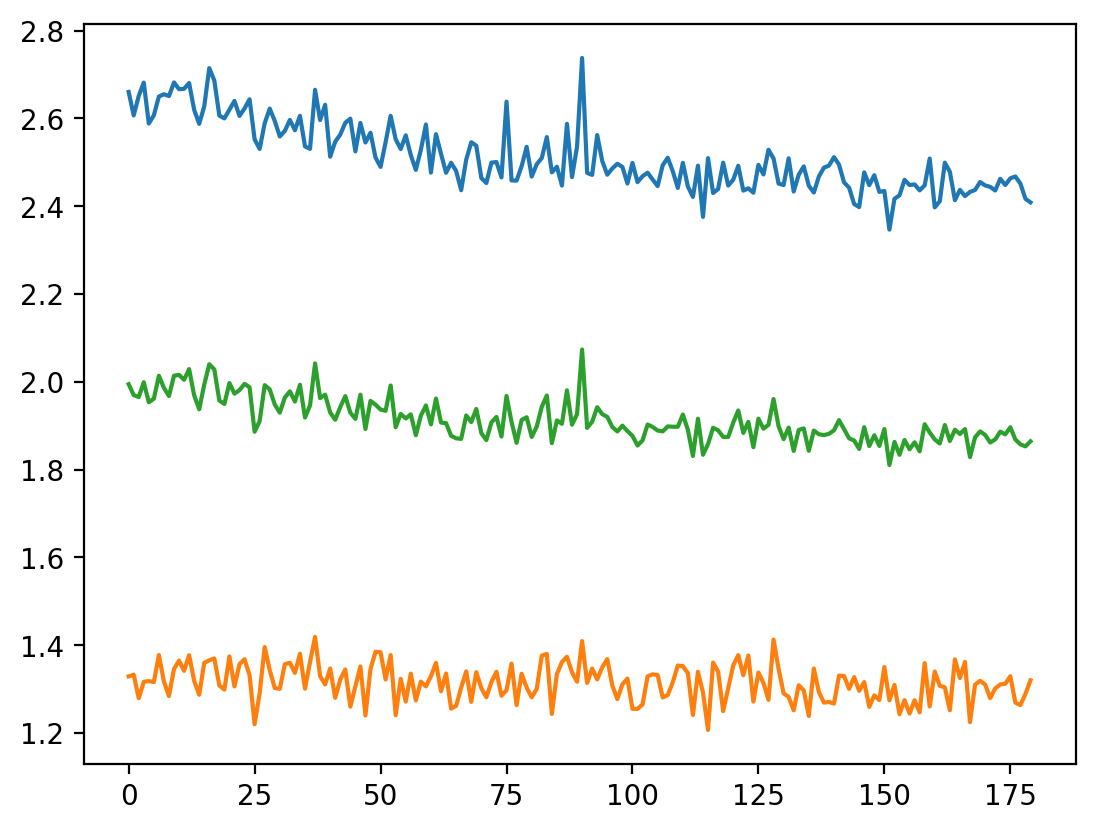

9000 | pitch: 2.41 | dur: 1.32
finished epoch: 1 | pitch: 2.46 | dur: 1.30


In [116]:
train_session(model, dataset, n_epochs=2, lr=0.001)

In [11]:
dataset = DatasetPRD(ds_prd, xy_split=[0.2, 0.8], trnasposition_augment_range=[-18, 18])

In [14]:
x, y = dataset[40]
interval = 0
x = prd.transpose(x, interval)
y = prd.transpose(y, interval)
print(x.T)

tensor([[129,  87, 128,  92,  85,  87,  87,  92,  89,  87,  85,  82, 128,  82,
          82,  75,  80,  79,  77,  75],
        [  1,  22,   9,   9,   9,   6,   6,   9,   6,   6,   9,   9,   9,   9,
           9,   9,   9,   6,   6,  15]])


In [12]:
model = Encodec(
    pitch_dims=[dataset.pitch_dim, 20],
    duration_dims=[dataset.duration_dim, 12],
    hidden_dim=128,
    num_layers=2
)


model_path = "../models/serialized/"
checkpoint = torch.load(f"{model_path}encodec-lstm-epoch2-random.pt")
model.load_state_dict(checkpoint)
h = model.init_hidden()

In [23]:
print(x[0])
p, d, h = model.encode_decode(torch.tensor([50, 9]), model.init_hidden())
# p, d, h = model.encode_decode(torch.tensor([65, 9]), h)
p.topk(4)[1], d.topk(4)[1]

tensor([129,   1])


(tensor([[51, 54, 49, 50]]), tensor([[ 9, 15,  6, 19]]))

In [16]:

def assess_distr(output: torch.Tensor, topk: int):
    distr, value = output.topk(topk)
    return torch.nn.functional.softmax(distr), value


def sample_from_distr(output, topk):
    distr, value = output.topk(topk)
    distr = torch.nn.functional.softmax(distr, dim=1)
    i = torch.distributions.categorical.Categorical(probs=distr).sample()
    return value.squeeze()[i].squeeze()

with torch.no_grad():
    hidden = model.init_hidden()
    for i in range(x.shape[0]-1):
        out, hidden = model.encode(x[i], hidden)
        o_pitch, o_duration, _ = model.decode(out, hidden)
        # print(x[i, 0], assess_distr(o_pitch, 5))


    print("---------------------------------------------")
    input = x[-1] 
    output_tune = []
    for i in range(x.shape[0]):
        o_pitch, o_duration, hidden = model.encode_decode(input, hidden)
        top_pitch_i = o_pitch.topk(1)[1].squeeze().detach()
        top_duration_i = o_duration.topk(1)[1].squeeze().detach()
        # print(assess_distr(o_pitch, 5))
        top_pitch_i = sample_from_distr(o_pitch, 4)
        top_duration_i = sample_from_distr(o_duration, 3)
        input = torch.stack([top_pitch_i, top_duration_i])
        # input = torch.stack([top_pitch_i, top_duration_i])
        if top_pitch_i == dataset.eot_code or top_duration_i == dataset.EOT_DUR_CODE:
            output_tune.append(torch.tensor([dataset.eot_code, dataset.EOT_DUR_CODE]))
            break
        output_tune.append(input)
print(len(output_tune), len(y))
pred = torch.stack(output_tune)
print(y.T)
print(pred.T)

---------------------------------------------
15 38
tensor([[ 65,  70,  69,  67,  65, 128,  77,  70,  72,  77,  72,  70,  69,  67,
          65,  70,  72,  70,  69,  67,  65, 128,  77,  70,  72,  77,  72,  70,
          69,  67,  65,  70,  72,  70,  69,  67,  65, 130],
        [  9,   9,   6,   6,  15,   9,   9,   9,   9,   9,   6,   6,   6,   6,
           9,  15,   6,   6,   6,   6,  22,   9,   9,   9,   9,   9,   6,   6,
           6,   6,   9,  15,   6,   6,   6,   6,  22,   2]])
tensor([[78, 78, 80, 80, 80, 82, 80, 80, 78, 77, 82, 82, 80, 82, 79],
        [ 9,  9,  9,  9,  9,  9,  9,  6,  9,  9,  9,  9,  9,  9,  6]])


In [17]:
dx = dataset.decode_durations([x.clone()])[0]
dy = dataset.decode_durations([y.clone()])[0]
dpred = dataset.decode_durations([pred.clone()])[0]
print(dy.T)
print(dpred.T)

out_path = "../data_out/"
tune = torch.concat([dx, dy])[1:-1].detach().numpy()
music = prd.to_muspy(tune, title="gt")
mp.write_midi(f"{out_path}gt.mid", music)

tune = torch.concat([dx, dpred])[1:-1].detach().numpy()
music = prd.to_muspy(tune, title="pred")
mp.write_midi(f"{out_path}pred.mid", music)

tensor([[ 65,  70,  69,  67,  65, 128,  77,  70,  72,  77,  72,  70,  69,  67,
          65,  70,  72,  70,  69,  67,  65, 128,  77,  70,  72,  77,  72,  70,
          69,  67,  65,  70,  72,  70,  69,  67,  65, 130],
        [ 12,  12,   6,   6,  24,  12,  12,  12,  12,  12,   6,   6,   6,   6,
          12,  24,   6,   6,   6,   6,  48,  12,  12,  12,  12,  12,   6,   6,
           6,   6,  12,  24,   6,   6,   6,   6,  48,  -1]])
tensor([[78, 78, 80, 80, 80, 82, 80, 80, 78, 77, 82, 82, 80, 82, 79],
        [12, 12, 12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12, 12,  6]])


In [250]:
torch.save(model.state_dict(), f"{model_path}encodec-lstm-epoch2-random.pt")

In [282]:
model = Encodec(
    pitch_dims=[dataset.pitch_dim, 20],
    duration_dims=[dataset.duration_dim, 12],
    hidden_dim=128,
    num_layers=2
)
checkpoint = torch.load(f"{model_path}encodec-lstm-epoch2-random.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>